In [15]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json
import os

load_dotenv()

model = ChatOpenAI(model_name="gpt-4o", temperature=0)

#response = model.invoke("Hello, how are you?")
#response

In [16]:
from urllib3 import response


search_tool = TavilySearchResults(max_results=4)
#response = search_tool.invoke("What is the latest news about the prime minister in France?")
#response

tools = [search_tool]
memory = MemorySaver()
llm_with_tools = model.bind_tools(tools)
#response = llm_with_tools.invoke("What is the current in Vanves, France?")
#response



In [17]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State) -> AIMessage:
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result]
    }

async def tools_router(state: State) -> ToolMessage:
    last_message = state["messages"][-1]
    
    if(hasattr(last_message,"tool_calls")) and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return END

async def tool_node(state: State) -> ToolMessage:
    # Get tool calls from last message
    tool_calls = state["messages"][-1].tool_calls
 
    # Initialize list to store messages
    tool_messages = []

    # Process each tool call
    for tool_call in tool_calls:
        # Get tool name and arguments
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        # handle the search tool
        if tool_name == "tavily_search_results_json":

            #Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)

            # Create tool message for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name,
            )

            tool_messages.append(tool_message)

    # Add the tool messages to the state    
    return {"messages": tool_messages}

# Update the graph construction
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)

# Set entry point
graph_builder.set_entry_point("model")

# Add conditional edges
graph_builder.add_conditional_edges("model", tools_router, 
    {
        "tool_node": "tool_node",
        END: END
    }
)

# Add edge from tool_node back to model
graph_builder.add_edge("tool_node", "model")

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)


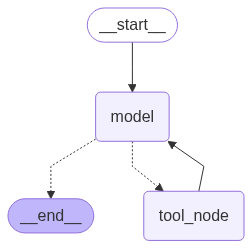

In [18]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [20]:
config ={
    "configurable": {
        "thread_id": 202509091
    }
}

response = await graph.ainvoke({"messages":[HumanMessage(content="When is the next spaceX launch?")]}, config=config)
response

{'messages': [HumanMessage(content='What is the latest news about Gaza?', additional_kwargs={}, response_metadata={}, id='445c5fa8-f79f-47fd-911d-7897d3c0078d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dRq01BRQEzGBzaSRDS3kPHCH', 'function': {'arguments': '{"query":"latest news about Gaza"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 87, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'id': 'chatcmpl-CDuRTi3IANOnRN5A7OjvgOrYyqLgo', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f5493b7d-17db-4d38-8d7d-c59649014a96-0', tool_calls=[{'name': 'tavily_search_resu

In [35]:
config ={
    "configurable": {
        "thread_id": 202509092
    }
}

async for event in graph.astream_events({
    "messages": [HumanMessage(content="Give me a 30 word essay on the next spaceX launch")]
}, config=config, version="v2") :
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)


Scheduled for September 10, 2025, SpaceX's next launch from Vandenberg SFB will use a Falcon 9 Block 5 rocket, advancing satellite deployment and showcasing reusable technology for sustainable space exploration.